# Kann mithilfe einer NLP-unterstützten Methodik festgestellt werden ob ein Amazon Review Positiv, Neutral oder Negativ ist, bzw. kann das angegebene Voting errechnet werden?

- Michael Hermann-Hubler
- Michael Kranl

The used data was created by J. Ni, J. Li, and J. McAuley for „Justifying Recommendations using Distantly-Labeled Reviews and Fine-Grained Aspects“, in Proceedings of the 2019 Conference on mpirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP), Hong Kong, China, 2019, S. 188–197. doi: 10.18653/v1/D19-1018. 

## Imports

In [ ]:
import sys
!{sys.executable} -m pip install gzinfo
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install wordcloud

In [34]:
# Intel Optimizer for Sklearn
# from sklearnex import patch_sklearn
# patch_sklearn()

# Pandas
import pandas as pd

# Numpy
import numpy as np

# Download
import urllib.request
import glob
import gzip
import gzinfo
import os
import shutil

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Preprocessing
from keras_preprocessing.text import text_to_word_sequence
import nltk
nltk.download('omw-1.4');
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import re

# Feature Representation
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Set to true on Production
final_Execution = False


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load Dataset

### Download Sub Dataset

In [2]:
subdatasets = [
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Arts_Crafts_and_Sewing_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Industrial_and_Scientific_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz',
                  'http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz'
              ]

def download(x: str):
    urllib.request.urlretrieve(x, '.data/dummy.gz')

    filename = gzinfo.read_gz_info('.data/dummy.gz').fname
    with gzip.open('.data/dummy.gz', 'rb') as f_in:
        with open('.data/' + filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
            
    os.remove('.data/dummy.gz')

# only run once as this can take a very long time
if len(os.listdir('.data') ) == 0:
    [download(x) for x in subdatasets]


## Load data

In [3]:
all_files = glob.glob('.data/*')
li = []

for filename in all_files:
    temp_df = pd.read_json(filename, lines=True)
    li.append(temp_df)

df = pd.concat(li, axis=0, ignore_index=True)

## Data Exploration I

In [4]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,True,"03 29, 2016",AIE8N9U317ZBM,0449819906,{'Format:': ' Kindle Edition'},"Zelmira, Ph.D.",Contains some interesting stitches.,Four Stars,1459209600,NaN,NaN
1,5,True,"08 12, 2015",A3ECOW0TWLH9V6,0449819906,{'Format:': ' Paperback'},Dangerous when Cooking,I'm a fairly experienced knitter of the one-co...,My current favorite go-to guide for inspiration,1439337600,18,NaN
2,4,True,"04 5, 2015",A278N8QX9TY2OS,0449819906,{'Format:': ' Paperback'},Just us,Great book but the index is terrible. Had to w...,"lots of great examples, good instructions, col...",1428192000,3,NaN
3,5,True,"10 11, 2014",A123W8HIK76XCN,0449819906,{'Format:': ' Kindle Edition'},Amazon Customer,I purchased the Kindle edition which is incred...,Another little gem by Melissa Leapman,1412985600,NaN,NaN
4,5,True,"05 8, 2014",A2A6MZ2QB4AE0L,0449819906,{'Format:': ' Paperback'},Sustainability,Very well laid out and very easy to read.\n\nT...,Very comprehensive,1399507200,NaN,NaN


In [5]:
df.describe()

,overall,unixReviewTime
count,837226.000000,8.372260e+05
mean,4.524777,1.446987e+09
std,0.953090,4.959673e+07
min,1.000000,1.051402e+09
25%,4.000000,1.418429e+09
50%,5.000000,1.452470e+09
75%,5.000000,1.483402e+09
max,5.000000,1.538525e+09


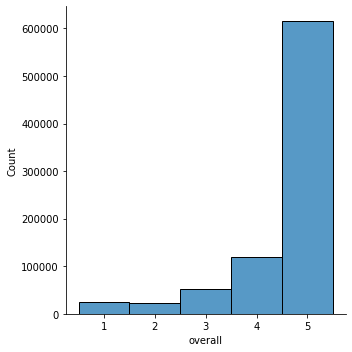

In [6]:
sns.displot(df.overall, discrete=True)

In [7]:
df.groupby('overall').count().reviewText

overall
1     25394
2     23489
3     52973
4    119795
5    615214
Name: reviewText, dtype: int64

The high average overall score means, that we have to split the data differently as we have no normal distibution.

In [8]:
print('Length whole Dataset:', len(df.reviewText))
print('Length Dataset without NA:', len(df.reviewText.dropna()))

Length whole Dataset: 837226
Length Dataset without NA: 836865


There exists missing Data

## Data Cleaning

### Remove unnessesary columns

In [9]:
df = df[['overall', 'reviewText']]

### Remove missing data

In [10]:
df = df.dropna()

### Reduce data to a representative subset
To reduce the data we take random 20.000 samples from each class, without replacement

In [11]:
sampling_size = 20000

li = [
    df[df.overall == 1].sample(sampling_size),
    df[df.overall == 2].sample(sampling_size),
    df[df.overall == 3].sample(sampling_size),
    df[df.overall == 4].sample(sampling_size),
    df[df.overall == 5].sample(sampling_size)
]

df_cleaned = pd.concat(li, axis=0, ignore_index=True)

In [12]:
df_cleaned.describe()

,overall
count,100000.000000
mean,3.000000
std,1.414221
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


In [13]:
df_cleaned.head()

,overall,reviewText
0,1,The colors themselves seem nice but the bottle...
1,1,"waste of money, fake reviews"
2,1,i cannot give a product review because the pro...
3,1,not the color I had hoped....an awful yellow
4,1,"These were push on, not set screw."


## Preprocessing

### Lowercasing

In [14]:
df_lowercase = df_cleaned.copy()
df_lowercase.reviewText = df_lowercase.reviewText.str.lower()
df_lowercase.head()

,overall,reviewText
0,1,the colors themselves seem nice but the bottle...
1,1,"waste of money, fake reviews"
2,1,i cannot give a product review because the pro...
3,1,not the color i had hoped....an awful yellow
4,1,"these were push on, not set screw."


### Remove Special Chars

In [15]:
regex = '[^ A-Za-z.,?!\\\\]+'

df_spec_cars_removed = df_lowercase.copy()
df_spec_cars_removed.reviewText = df_spec_cars_removed.apply(lambda row: re.sub(regex, '', row.reviewText), axis=1)
df_spec_cars_removed.head()

,overall,reviewText
0,1,the colors themselves seem nice but the bottle...
1,1,"waste of money, fake reviews"
2,1,i cannot give a product review because the pro...
3,1,not the color i had hoped....an awful yellow
4,1,"these were push on, not set screw."


### Tokenization

In [16]:
df_token = df_spec_cars_removed.copy()
df_token.reviewText = df_token.apply(lambda row: text_to_word_sequence(row.reviewText), axis=1)
df_token.head()

,overall,reviewText
0,1,"[the, colors, themselves, seem, nice, but, the..."
1,1,"[waste, of, money, fake, reviews]"
2,1,"[i, cannot, give, a, product, review, because,..."
3,1,"[not, the, color, i, had, hoped, an, awful, ye..."
4,1,"[these, were, push, on, not, set, screw]"


### Lemmatization 

In [17]:
lemmatizer = WordNetLemmatizer()

df_lemm = df_token.copy()
df_lemm.reviewText = df_lemm.apply(lambda row: [lemmatizer.lemmatize(x) for x in row.reviewText], axis=1)
df_lemm.head()

,overall,reviewText
0,1,"[the, color, themselves, seem, nice, but, the,..."
1,1,"[waste, of, money, fake, review]"
2,1,"[i, cannot, give, a, product, review, because,..."
3,1,"[not, the, color, i, had, hoped, an, awful, ye..."
4,1,"[these, were, push, on, not, set, screw]"


### Stemming

Stemming ist used additionally to lemtization, because time forms were not normalized

In [18]:
stemmer = PorterStemmer()

df_stemm = df_lemm.copy()
df_stemm.reviewText = df_stemm.apply(lambda row: [stemmer.stem(x) for x in row.reviewText], axis=1)
df_stemm.head()

,overall,reviewText
0,1,"[the, color, themselv, seem, nice, but, the, b..."
1,1,"[wast, of, money, fake, review]"
2,1,"[i, cannot, give, a, product, review, becaus, ..."
3,1,"[not, the, color, i, had, hope, an, aw, yellow]"
4,1,"[these, were, push, on, not, set, screw]"


### Stopword removal

In [19]:
stopwords_en = stopwords.words('english')

df_removed_stopwords = df_stemm.copy()
df_removed_stopwords.reviewText = df_removed_stopwords.apply(lambda row: [x for x in row.reviewText if x not in stopwords_en and x not in ['\n', '\r']], axis=1)
df_removed_stopwords.head()

,overall,reviewText
0,1,"[color, themselv, seem, nice, bottl, leak, ter..."
1,1,"[wast, money, fake, review]"
2,1,"[cannot, give, product, review, becaus, produc..."
3,1,"[color, hope, aw, yellow]"
4,1,"[push, set, screw]"


### Define final

In [20]:
df_final = df_removed_stopwords[df_removed_stopwords.reviewText.map(lambda d: len(d)) > 0]
df_final

,overall,reviewText
0,1,"[color, themselv, seem, nice, bottl, leak, ter..."
1,1,"[wast, money, fake, review]"
2,1,"[cannot, give, product, review, becaus, produc..."
3,1,"[color, hope, aw, yellow]"
4,1,"[push, set, screw]"
...,...,...
99995,5,"[sturdi, goos, neck, without, stiff, pleasur, ..."
99996,5,"[simpl, inexpens, reason, durabl, last, snark,..."
99997,5,"[perfect, light, coverag, foundat]"
99998,5,"[got, standard, hot, glue, gun, walmart, work,..."


## Data Exploration II

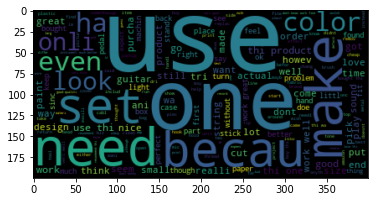

In [21]:
word_list = df_final.reviewText.tolist()
word_list = [i for j in word_list for i in j]

word_list_text = ' '.join(word_list)

wordcloud = WordCloud().generate(word_list_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

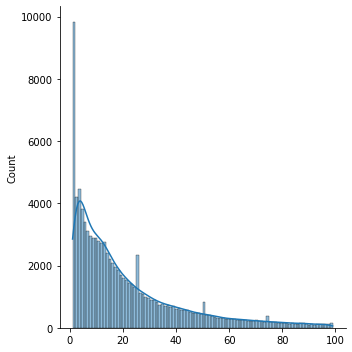

In [22]:
word_counts = [df_final.reviewText.apply(len)][0]
word_counts = [x for x in word_counts if x < 100]

sns.displot(word_counts, kde=True)

In [23]:
[x for x in df_final.reviewText if len(x) < 5][:10]


[['wast', 'money', 'fake', 'review'],
 ['color', 'hope', 'aw', 'yellow'],
 ['push', 'set', 'screw'],
 ['doesnt', 'work'],
 ['could', 'get', 'start', 'wast'],
 ['brake', 'easi'],
 ['broke', 'first', 'time', 'use'],
 ['expect'],
 ['horribl', 'materi'],
 ['dont', 'bother', 'didnt', 'glow']]

These results with just one word seem plausible, thus they will be included

## Feature Representation

### n-Gram

In [24]:
n = 3
ngram = ngrams(df_final.reviewText, n)

df_ngram = df_final.copy()
df_ngram['ngram'] = df_ngram.reviewText

df_ngram.loc[df_ngram.reviewText.apply(len) >= n, 'ngram'] = [list(ngrams(x, n)) for x in df_ngram.reviewText if len(x) >= n]

df_ngram

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,overall,reviewText,ngram
0,1,"[color, themselv, seem, nice, bottl, leak, ter...","[(color, themselv, seem), (themselv, seem, nic..."
1,1,"[wast, money, fake, review]","[(wast, money, fake), (money, fake, review)]"
2,1,"[cannot, give, product, review, becaus, produc...","[(cannot, give, product), (give, product, revi..."
3,1,"[color, hope, aw, yellow]","[(color, hope, aw), (hope, aw, yellow)]"
4,1,"[push, set, screw]","[(push, set, screw)]"
...,...,...,...
99995,5,"[sturdi, goos, neck, without, stiff, pleasur, ...","[(sturdi, goos, neck), (goos, neck, without), ..."
99996,5,"[simpl, inexpens, reason, durabl, last, snark,...","[(simpl, inexpens, reason), (inexpens, reason,..."
99997,5,"[perfect, light, coverag, foundat]","[(perfect, light, coverag), (light, coverag, f..."
99998,5,"[got, standard, hot, glue, gun, walmart, work,...","[(got, standard, hot), (standard, hot, glue), ..."


### TF-IDF

In [25]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=(lambda x:x),
    preprocessor=(lambda x:x),
    token_pattern=None
)

vectorizer.fit(df_final.reviewText)
vectorizer.vocabulary_

{'color': 7223,
 'themselv': 41845,
 'seem': 36468,
 'nice': 27384,
 'bottl': 4325,
 'leak': 22921,
 'terribl': 41614,
 'thank': 41720,
 'store': 39945,
 'plastic': 31334,
 'seal': 36373,
 'bin': 3613,
 'becaus': 3134,
 'everywher': 12984,
 'even': 12928,
 'make': 24357,
 'sure': 40757,
 'tight': 42435,
 'tri': 43272,
 'turn': 43646,
 'squeez': 39283,
 'enough': 12533,
 'hand': 17109,
 'countertop': 8580,
 'etc': 12833,
 'complet': 7796,
 'stain': 39406,
 'ive': 21473,
 'wash': 46050,
 'repeatedli': 34516,
 'ha': 16938,
 'realli': 33853,
 'budg': 4889,
 'definit': 9828,
 'recommend': 34034,
 'wast': 46095,
 'money': 26244,
 'fake': 13473,
 'review': 34889,
 'cannot': 5461,
 'give': 15847,
 'product': 32602,
 'wa': 45850,
 'miss': 25912,
 'packag': 29743,
 'hope': 18307,
 'aw': 2419,
 'yellow': 47736,
 'push': 33203,
 'set': 36803,
 'screw': 36265,
 'flat': 14279,
 'radiu': 33583,
 'unus': 44687,
 'anyth': 1571,
 'degre': 9852,
 'thi': 41989,
 'spray': 39173,
 'releas': 34379,
 'button'

## Clustering

### Preparing Sample
A sample is needed because of memory Reasons

In [26]:
df_sample = df_final.sample(n=(int)(sampling_size/10))
X = vectorizer.transform(df_sample.reviewText)
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## KMeans + PCA

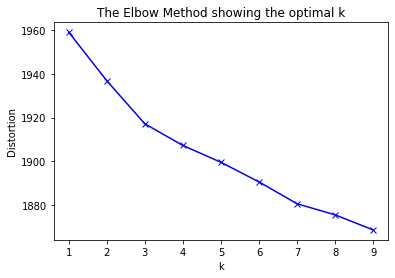

In [30]:
# do Ellbow Plot only for final Execution, as this takes a very long time

if final_Execution:
    distortions = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(X)
        distortions.append(kmeanModel.inertia_)    

    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()



Upper Limit of 20, because the Optimum (~35) cannot be displayed

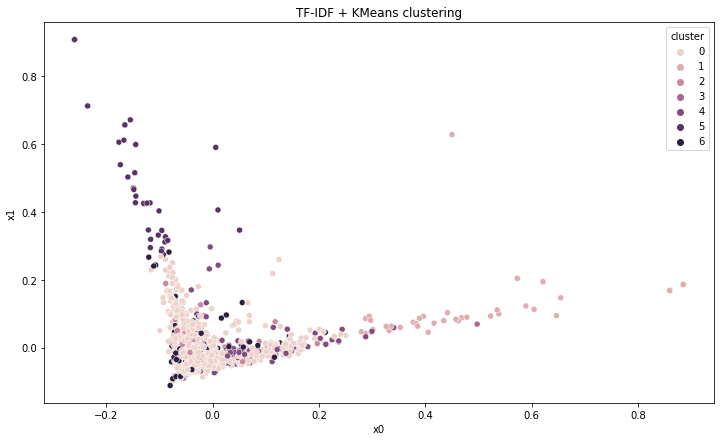

In [56]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)
clusters = kmeans.labels_

pca = PCA(n_components=2, random_state=42)
pca_vecs = pca.fit_transform(X.toarray())

df_sample['cluster'] = clusters
df_sample['x0'] = pca_vecs[:, 0]
df_sample['x1'] = pca_vecs[:, 1]

plt.figure(figsize=(12, 7))
plt.title("TF-IDF + KMeans clustering")
sns.scatterplot(data=df_sample, x='x0', y='x1', hue='cluster')
plt.show()

### TSNE

C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\micha\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.292s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.313824
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.628880
[t-SNE] KL divergence after 1000 iterations: 1.073881


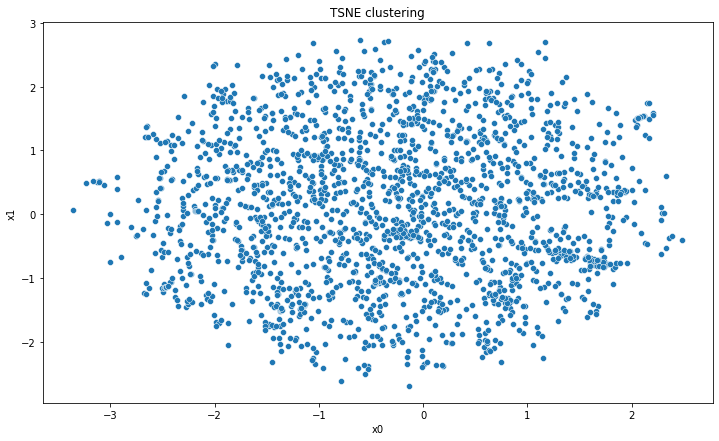

In [54]:
model = TSNE(n_components=2, verbose=1, perplexity=500)
z = model.fit_transform(X)

#df_sample['cluster'] = clusters
df_sample['x0'] = z[:,0]
df_sample['x1'] = z[:,1]

plt.figure(figsize=(12, 7))
plt.title("TSNE clustering")
sns.scatterplot(data=df_sample, x='x0', y='x1')
plt.show()